# Ordinal Regression

Some data are discrete but instrinsically **ordered**, these are called [**ordinal**](https://en.wikipedia.org/wiki/Ordinal_data) data. One example is the [likert scale](https://en.wikipedia.org/wiki/Likert_scale) for questionairs ("this is an informative tutorial": 1. strongly disagree / 2. disagree / 3. neither agree nor disagree / 4. agree / 5. strongly agree). Ordinal data is also ubiquitous in the medical world (e.g. the [Glasgow Coma Scale](https://en.wikipedia.org/wiki/Glasgow_Coma_Scale) for measuring neurological disfunctioning). 

This poses a challenge for statistical modeling as the data do not fit the most well known modelling approaches (e.g. linear regression). Modeling the data as [categorical](https://en.wikipedia.org/wiki/Categorical_distribution) is one possibility, but it disregards the inherent ordering in the data, and may be less statistically efficient. There are multiple appoaches for modeling ordered data. Here we will show how to use the OrderedLogistic distribution using cutpoints that are sampled from a Normal distribution with as additional constrain that the cutpoints they are ordered. For a more in-depth discussion of Bayesian modeling of ordinal data, see e.g. [Michael Betancour's blog](https://betanalpha.github.io/assets/case_studies/ordinal_regression.html)

In [1]:
from jax import numpy as np, random
import numpyro
from numpyro import sample
from numpyro.distributions import (Categorical, ImproperUniform, Normal, OrderedLogistic,
                                   TransformedDistribution, constraints, transforms)
from numpyro.infer import MCMC, NUTS
import pandas as pd
import seaborn as sns
assert numpyro.__version__.startswith('0.4.0')

First, generate some data with ordinal structure

In [2]:
simkeys  = random.split(random.PRNGKey(1), 2)
nsim     = 50
nclasses = 3
Y        = Categorical(logits=np.zeros(nclasses)).sample(simkeys[0], sample_shape=(nsim,))
X        = Normal().sample(simkeys[1], sample_shape = (nsim,))
X       += Y

print("value counts of Y:")
df = pd.DataFrame({'X': X, 'Y': Y})
print(df.Y.value_counts())

for i in range(nclasses):
    print(f"mean(X) for Y == {i}: {X[np.where(Y==i)].mean():.3f}")

value counts of Y:
1    19
2    16
0    15
Name: Y, dtype: int64
mean(X) for Y == 0: 0.042
mean(X) for Y == 1: 0.832
mean(X) for Y == 2: 1.448


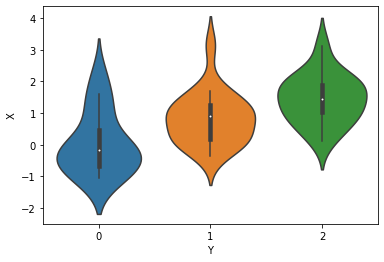

In [3]:
sns.violinplot(x='Y', y='X', data=df);

We will model the outcomes Y as coming from an OrderedLogistic distribution, conditional on X. The `OrderedLogistic` distribution in numpyro requires ordered cutpoints. We can use the `ImproperUnifrom` distribution to introduce a parameter with an arbitrary support that is otherwise completely uninformative, and then add an `ordered_vector` constraint.

In [4]:
def model1(X, Y, nclasses=3):
    b_X_eta = sample('b_X_eta', Normal(0, 5))
    c_y     = sample('c_y',     ImproperUniform(support=constraints.ordered_vector,
                                                batch_shape=(),
                                                event_shape=(nclasses-1,)))
    with numpyro.plate('obs', X.shape[0]):
        eta = X * b_X_eta
        sample('Y', OrderedLogistic(eta, c_y), obs=Y)

mcmc_key = random.PRNGKey(1234)
kernel = NUTS(model1)
mcmc   = MCMC(kernel, num_warmup=250, num_samples=750)
mcmc.run(mcmc_key, X,Y, nclasses)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:07<00:00, 126.55it/s, 7 steps of size 4.34e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   b_X_eta      1.43      0.35      1.42      0.82      1.96    352.72      1.00
    c_y[0]     -0.11      0.41     -0.11     -0.78      0.55    505.85      1.00
    c_y[1]      2.18      0.52      2.15      1.35      2.95    415.22      1.00

Number of divergences: 0


The `ImproperUniform` distribution allows us to use parameters with constraints on their domain, without adding any additional information e.g. about the location or scale of the prior distribution on that parameter.

If we want to incorporate such information, for instance that the values of the cut-points should not be too far from zero, we can add an additional `sample` statement that uses another prior, coupled with an `obs` argument. In the example below we first sample cutpoints `c_y` from the `ImproperUniform` distribution with `constraints.ordered_vector` as before, and then `sample` a dummy parameter from a `Normal` distribution while conditioning on `c_y` using `obs=c_y`. Effectively, we've created an improper / unnormalized prior that results from restricting the support of a `Normal` distribution to the ordered domain

In [5]:
def model2(X, Y, nclasses=3):
    b_X_eta = sample('b_X_eta', Normal(0, 5))    
    c_y     = sample('c_y',     ImproperUniform(support=constraints.ordered_vector,
                                                batch_shape=(),
                                                event_shape=(nclasses-1,)))
    sample('c_y_smp', Normal(0,1), obs=c_y)
    with numpyro.plate('obs', X.shape[0]):
        eta = X * b_X_eta
        sample('Y', OrderedLogistic(eta, c_y), obs=Y)

kernel = NUTS(model2)
mcmc   = MCMC(kernel, num_warmup=250, num_samples=750)
mcmc.run(mcmc_key, X,Y, nclasses)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:03<00:00, 315.02it/s, 7 steps of size 4.80e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   b_X_eta      1.23      0.30      1.23      0.69      1.65    535.41      1.00
    c_y[0]     -0.25      0.33     -0.25     -0.82      0.27    461.96      1.00
    c_y[1]      1.76      0.38      1.75      1.10      2.33    588.10      1.00

Number of divergences: 0


If having a proper prior for those cutpoints `c_y` is desirable (e.g. to sample from that prior and get [prior predictive](https://en.wikipedia.org/wiki/Posterior_predictive_distribution#Prior_vs._posterior_predictive_distribution)), we can use [TransformedDistribution](http://num.pyro.ai/en/stable/distributions.html#transformeddistribution) with an [OrderedTransform](http://num.pyro.ai/en/stable/distributions.html#orderedtransform) transform as follows.

In [6]:
def model3(X, Y, nclasses=3):
    b_X_eta = sample('b_X_eta', Normal(0, 5))    
    c_y     = sample("c_y",     TransformedDistribution(Normal(0, 1).expand([nclasses - 1]),
                                                        transforms.OrderedTransform()))
    with numpyro.plate('obs', X.shape[0]):
        eta = X * b_X_eta
        sample('Y', OrderedLogistic(eta, c_y), obs=Y)

kernel = NUTS(model3)
mcmc   = MCMC(kernel, num_warmup=250, num_samples=750)
mcmc.run(mcmc_key, X,Y, nclasses)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:03<00:00, 282.20it/s, 7 steps of size 4.84e-01. acc. prob=0.94]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   b_X_eta      1.41      0.34      1.40      0.88      2.00    444.42      1.00
    c_y[0]     -0.05      0.36     -0.05     -0.58      0.54    591.60      1.00
    c_y[1]      2.08      0.47      2.07      1.37      2.87    429.27      1.00

Number of divergences: 0
